# **실습1: 피마 인디언 당뇨병 결정 모델**
자료 속성 (8가지 피처들)
1. 임신 횟수
2. 경구 포도당 내성 검사에서 혈장 포도당 농도
3. 확장기 혈압
4. 삼두근 피부 두께
5. 인슐린 혈청 저항성
6. 체질량 지수
7. 당뇨병 병력 함수
8. 나이

**당뇨병 진단 결과  0:당뇨병 아님,  1:당뇨병**


In [1]:
from numpy import loadtxt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd

In [2]:
dataset = loadtxt('https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv', delimiter=',')

In [3]:
dataset

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [6]:
# 데이터 분리
X = dataset[:, 0:8]
y = dataset[:, 8]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

# 모델 학습 시키기
model = XGBClassifier()
model.fit(x_train, y_train)
# make predictions
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluations
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 81.17%


In [7]:
# 특정 데이터에 대해 예측을 해보자

patient = {
    'Pregnancies': [1],
    'Glucose': [161],
    'BloodPressure': [72],
    'SkinThickness': [35],
    'Insulin': [0],
    'BMI': [28.1],
    'DiabetesPedigreeFunction': [0.527],
    'Age': [20]
}
value = [1, 161, 72, 35, 0, 28.1, 0.527, 20]
l = model.predict_proba(value)
print('No diabetes: {:.2%}\n Yes diabetes: {:.2%}'.format(l[0][0], l[0][1]))


No diabetes: 69.09%
 Yes diabetes: 30.91%


**80% 정답률, 이러한 정답률이 나온 이유에 대해서 설명하기**

기존 방식으로는 설명하기 애매하다. 가령, 환자에게 어떻게 설명할 것인가?

XAI기법을 이용해 일반인도 모델을 신뢰할수 있게끔 현실적인 근거를 만들자.

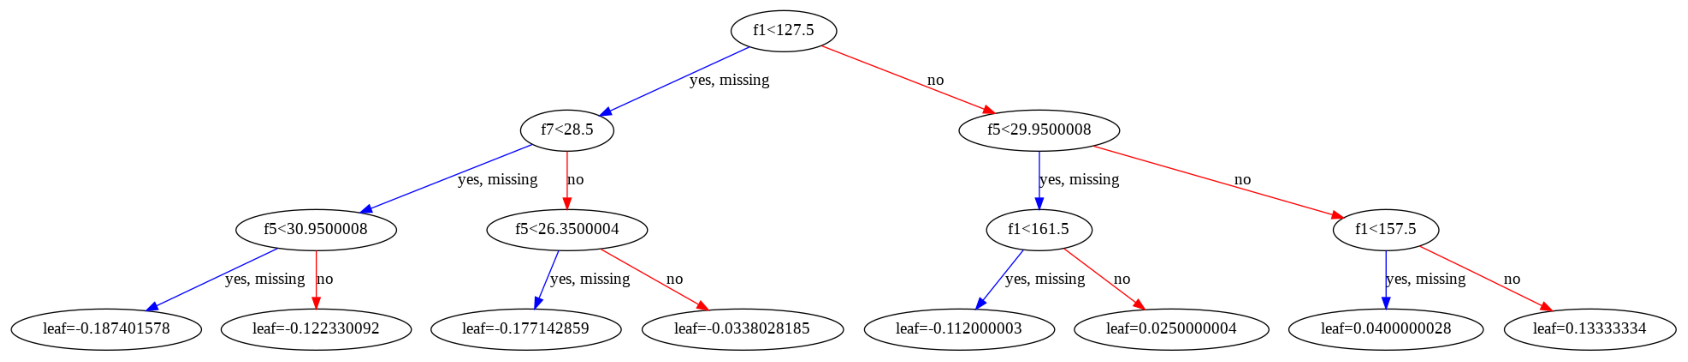

In [8]:
# 4.3  Graphviz 패키지를 이용해 모델의 의사 결정 나무를 시각화하는 코드
#현재 브라우저에 이미지를 표시하는 명령어
%matplotlib inline  

import os
# set graphviz path
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# set up the parameters
rcParams['figure.figsize'] = 30,60  #rcParams는 차트를 시각화하기
# 의사 결정 트리 시각화
plot_tree(model)
plt.show()


**로지스틱 회귀(Logistic Regression)**

둘 중 하나를 결정하는 문제를 이진 분류(Binary Classification)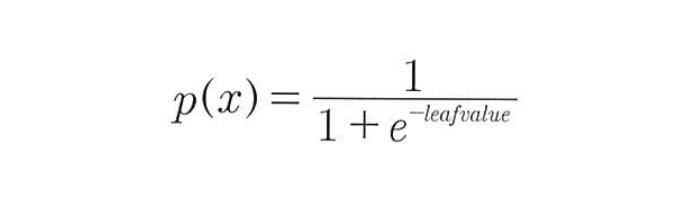

**가지가 너무 많다고 생각되면? -> 프루닝(가지치기)**

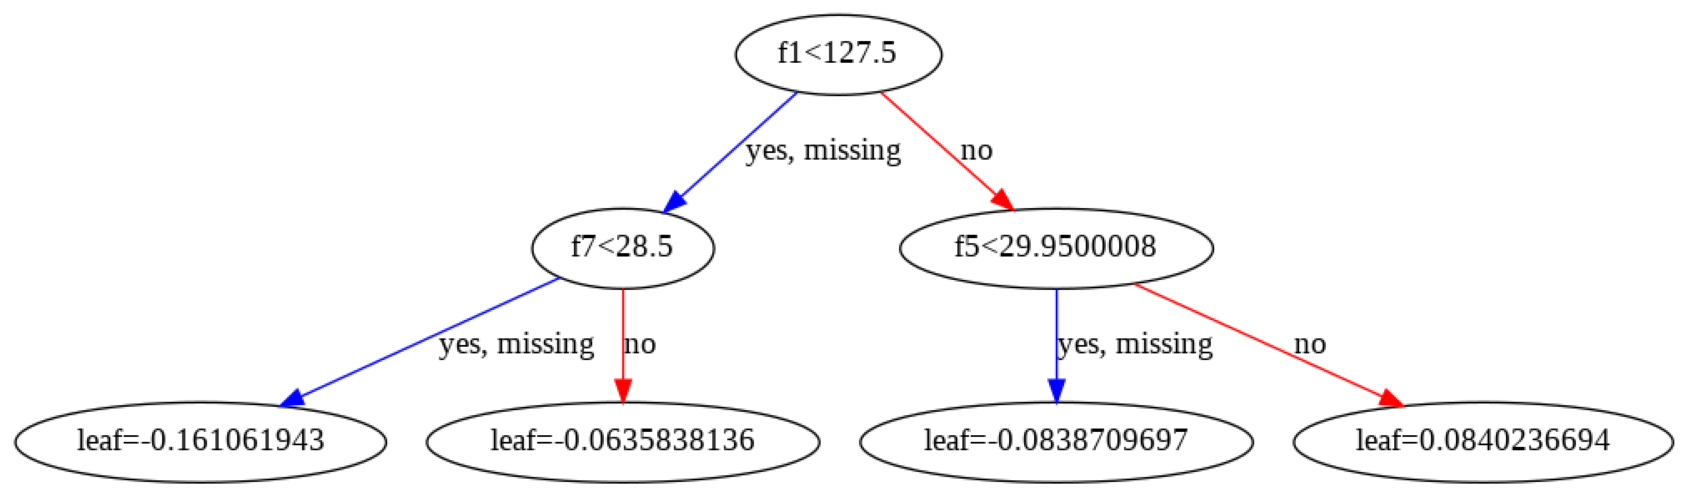

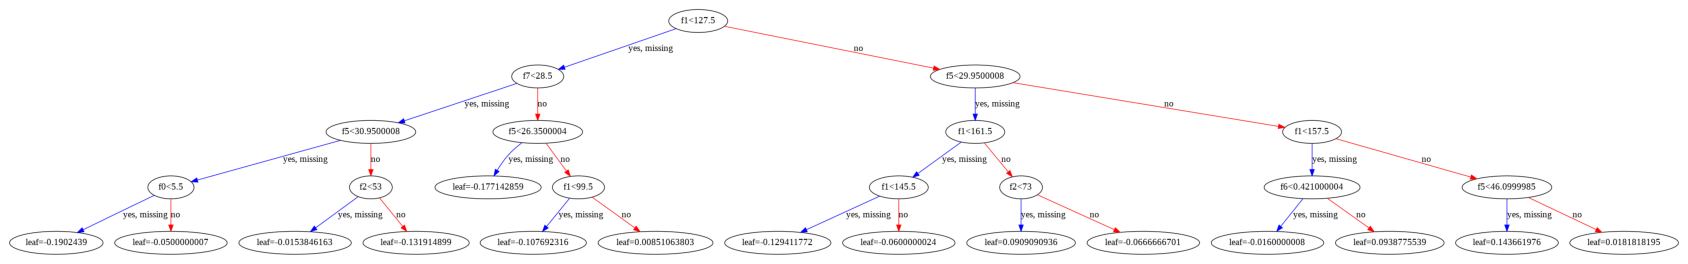

In [9]:
#  예제 4.7 XGBClassifier의 max_depth 옵션을 조절해 의사 결정 나무를 가지 치는 코드

model1 = XGBClassifier(max_depth=2)
model1.fit(x_train, y_train)

plot_tree(model1)
plt.show()

model = XGBClassifier(max_depth=4)
model.fit(x_train, y_train)

plot_tree(model)
plt.show()


**의사결정트리 시각화 : 모델이 어떤 비중으로 특청 피처를 우선순위로 생각하는지 알수 있다.**

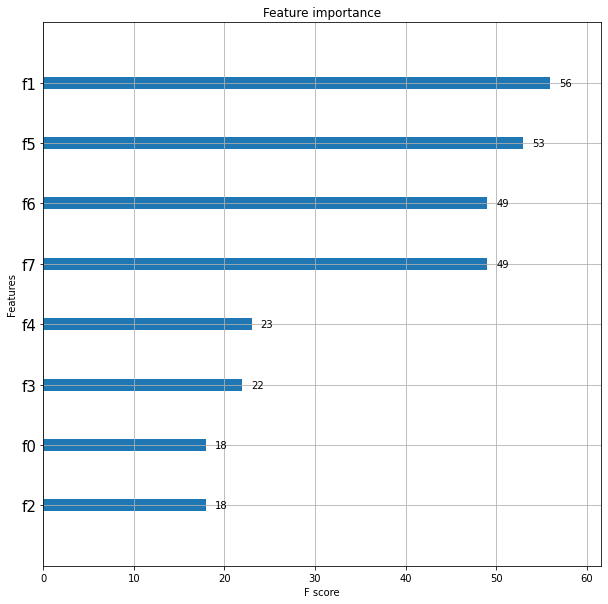

In [10]:
# 예제 4.8 당뇨병 진단 모델의 피처 중요도를 계산하고 시각화하는 코드

from xgboost import plot_importance
# figure size change
rcParams['figure.figsize'] = 10, 10
plot_importance(model1)
plt.yticks(fontsize=15)
plt.show()


**피처 중요도 판단의 한계점**

1. 해당 피처가 모델 판단에 긍정적인 영향인지 부정적인 영향인지 알 수 없다.
2. 피처간 종속적인 관계에 대해 판단하지 못한다.

**부분 의존성 플롯을 통해 한계점을 해결할 수 있다.**

In [11]:
# 예제 4.9 pdpbox를 사용해 GTT 피처에 대한 목표 플롯(Target plots)을 그리는 코드
!pip install pdpbox  # PDP 툴박스 설치

     |████████████████████████████████| 34.0 MB 78 kB/s 
     |████████████████████████████████| 13.1 MB 59.6 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=39676b2592812a77b5aac167bbc6ad6beea241a063cbaf93456b2beb1be9d170
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [12]:
from pdpbox import pdp, info_plots
pima_data = data

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


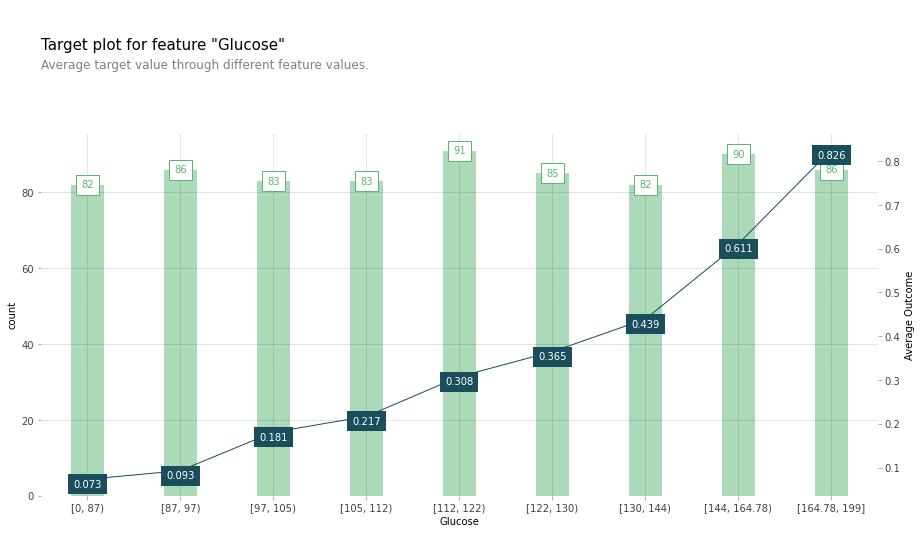

In [13]:
pima_features = data.columns[:8]
pima_target = data.columns[8]
fig, axes, summary_df = info_plots.target_plot( df=pima_data, feature='Glucose', feature_name='Glucose', target=pima_target )
#구간별 데이터 개수와 확률

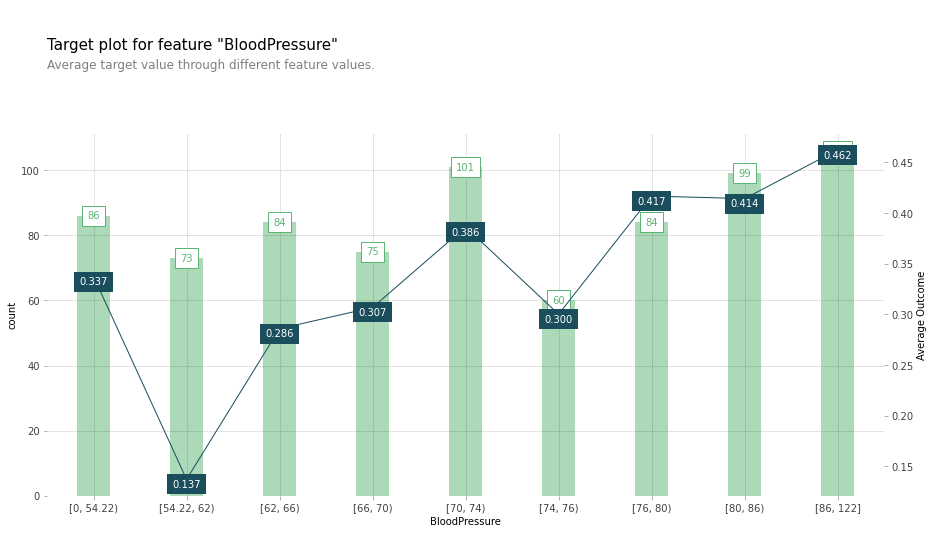

In [14]:
pima_features = data.columns[:8]
pima_target = data.columns[8]
fig, axes, summary_df = info_plots.target_plot( df=pima_data, feature='BloodPressure', feature_name='BloodPressure', target=pima_target )

**혈압으로만 당뇨병 판단하는 것은 섣부른 판단이다.**

In [15]:
summary_df
#혈압에 대한 당뇨병 진단

,x,display_column,value_lower,value_upper,count,Outcome
0,0,"[0, 54.22)",0.000000,54.222222,86,0.337209
1,1,"[54.22, 62)",54.222222,62.000000,73,0.136986
2,2,"[62, 66)",62.000000,66.000000,84,0.285714
3,3,"[66, 70)",66.000000,70.000000,75,0.306667
4,4,"[70, 74)",70.000000,74.000000,101,0.386139
5,5,"[74, 76)",74.000000,76.000000,60,0.300000
6,6,"[76, 80)",76.000000,80.000000,84,0.416667
7,7,"[80, 86)",80.000000,86.000000,99,0.414141
8,8,"[86, 122]",86.000000,122.000000,106,0.462264


In [16]:
data.rename(columns = {'Pregnancies':'f0', 'Glucose':'f1', 'BloodPressure':'f2', 'SkinThickness':'f3', 'Insulin':'f4', 'BMI':'f5', 'DiabetesPedigreeFunction':'f6', 'Age':'f7'}, inplace = True)

In [17]:
pima_features = data.columns[:8]

**info_plots.target_plot** 데이터만 분석해서 플롯을 그린다

**info_plots.actual_plot** 학습된 모델까지 이용해서 플롯을 그린다

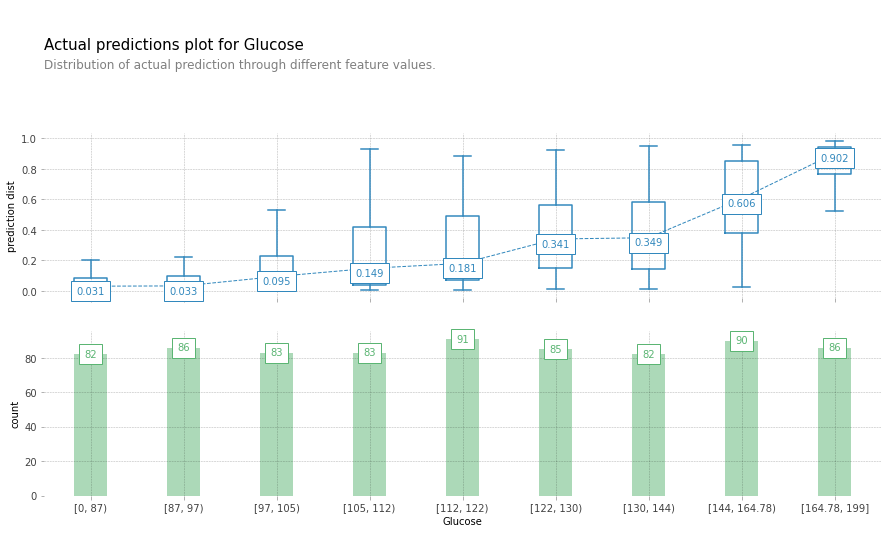

In [18]:
# 예제 4.10 GTT 데이터에 대한 모델의 실제 예측 분포 플롯을 그리는 코드

fig, axes, summary_df = info_plots.actual_plot(
    model=model,
    X=pima_data[pima_features],
    feature='f1',
    feature_name='Glucose',
    predict_kwds={}
)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


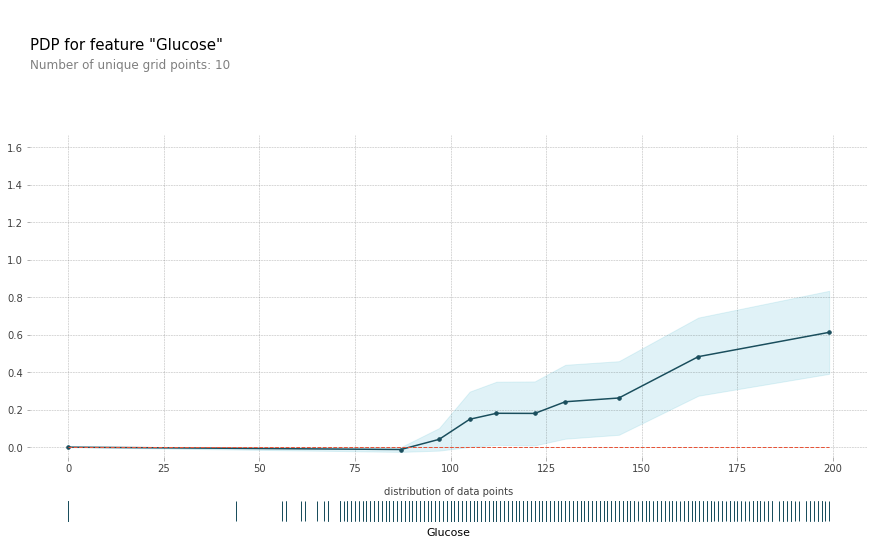

In [19]:
# 예제 4.11 GTT 테스트 피처에 대해 부분 의존성을 계산하고 플롯을 그리는 코드

# pdp isolation plot
pdp_gc = pdp.pdp_isolate(
    model=model,
    dataset=pima_data,
    model_features=pima_features,
    feature='f1'
)

# plot information
fig, axes = pdp.pdp_plot(
    pdp_gc,
    'Glucose',
    plot_lines=False,
    frac_to_plot=0.5,
    plot_pts_dist=True
)


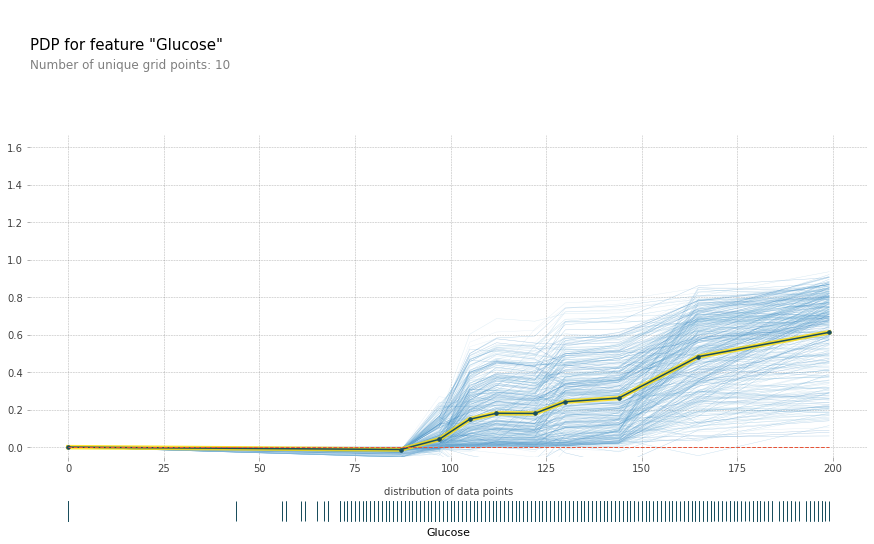

In [20]:
# 예제 4.11 GTT 테스트 피처에 대해 부분 의존성을 계산하고 플롯을 그리는 코드

# pdp isolation plot
pdp_gc = pdp.pdp_isolate(
    model=model,
    dataset=pima_data,
    model_features=pima_features,
    feature='f1'
)

# plot information
fig, axes = pdp.pdp_plot(
    pdp_gc,
    'Glucose',
    plot_lines=True, #부분 의존성 알고리즘 매회에 대응하는 별도의 라인이 표시됨
    frac_to_plot=0.5,
    plot_pts_dist=True
)


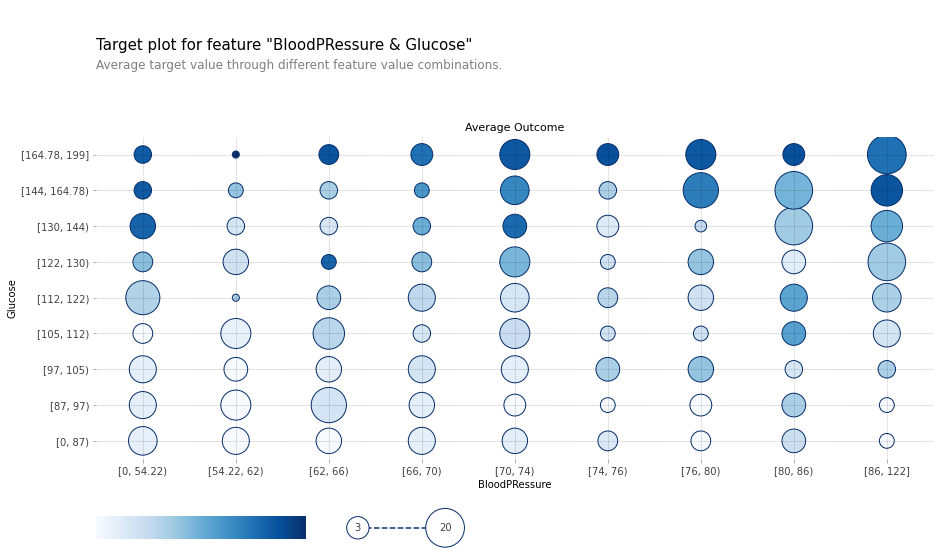

In [21]:
# 예제 4.12 혈압과 GTT 테스트 데이터 두 피처에 대해 목표 플롯을 그리는 코드
fig, axes, summary_df = info_plots.target_plot_interact(
    df=pima_data,
    features=['f2', 'f1'],
    feature_names=['BloodPRessure', 'Glucose'],
    target=pima_target
)

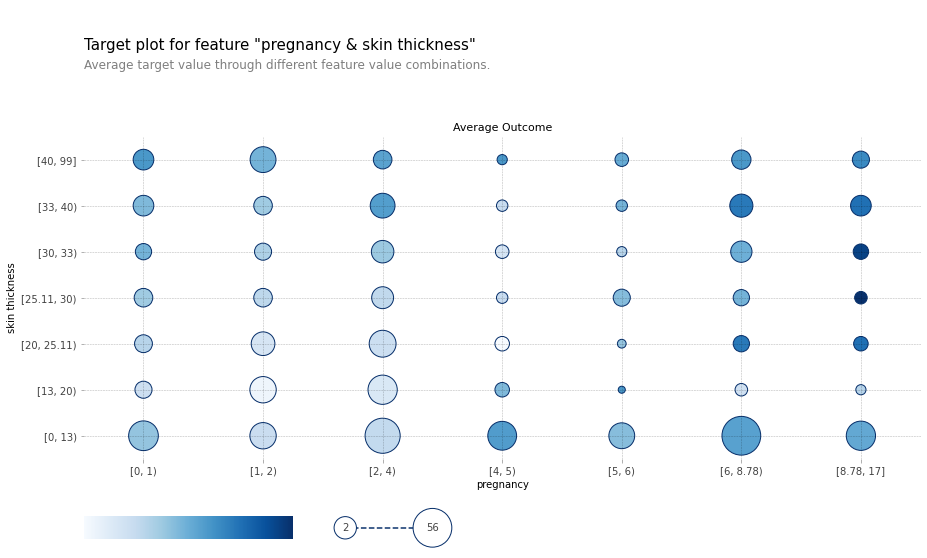

In [22]:
# 예제 4.12 혈압과 GTT 테스트 데이터 두 피처에 대해 목표 플롯을 그리는 코드
fig, axes, summary_df = info_plots.target_plot_interact(
    df=pima_data,
    features=['f0', 'f3'],
    feature_names=['pregnancy', 'skin thickness'],
    target=pima_target
)

**원이 커질수록 사례가 많아진다.**  
**원이 진할록 당뇨병 진단 가능성이 높아진다.**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


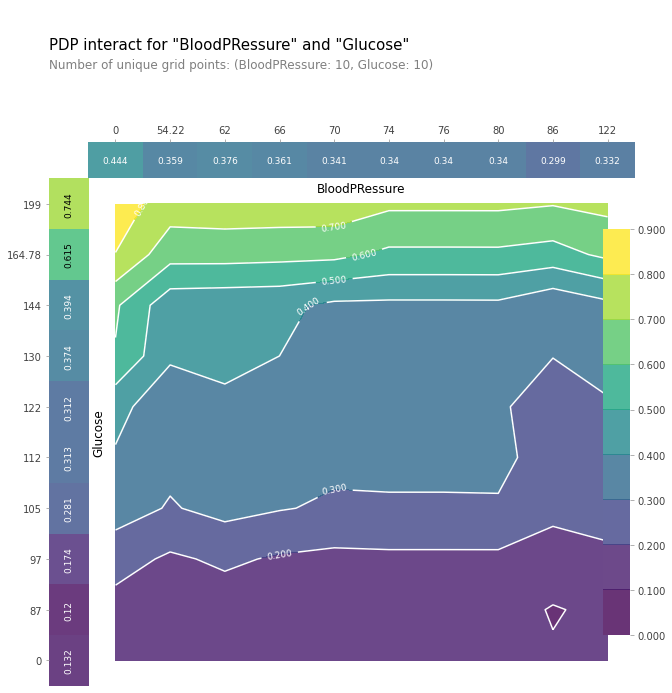

In [23]:
# 예제 4.13 혈압과 GTT 테스트 데이터로 모델에 대한 부분 의존성 플롯을 그리는 코드

pdp_interaction = pdp.pdp_interact(
    model=model,
    dataset=pima_data,
    model_features=pima_features,
    features=['f2', 'f1']
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_interaction,
    feature_names=['BloodPRessure', 'Glucose'],
    plot_type='contour',
    x_quantile=True,
    plot_pdp=True
)


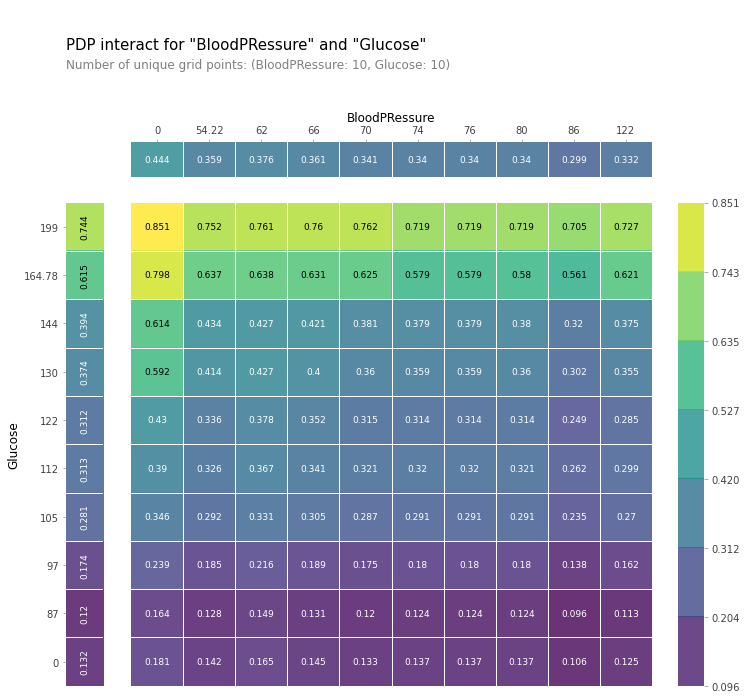

In [24]:
# 예제 4.13 혈압과 GTT 테스트 데이터로 모델에 대한 부분 의존성 플롯을 그리는 코드

pdp_interaction = pdp.pdp_interact(
    model=model,
    dataset=pima_data,
    model_features=pima_features,
    features=['f2', 'f1']
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_interaction,
    feature_names=['BloodPRessure', 'Glucose'],
    plot_type='grid',
    x_quantile=True,
    plot_pdp=True
)


X축은 BloodPressure, Y축은 Glucose 

 등고선의 색이 옅어질수록 당뇨병 진단 가능성 상승 

 X축에 평행하니 BloodPressure보다 Glucose에 더 많이 의존

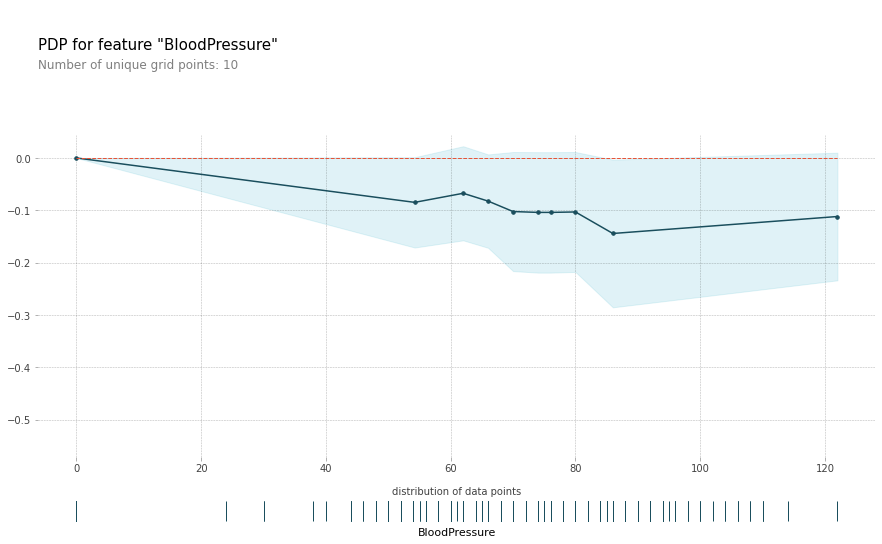

In [25]:
# 예제 4.14 혈압 피처에 대해 부분 의존성 플롯을 그리는 코드

# calculate model with BloodPressure to express pdp
pdp_bp = pdp.pdp_isolate(
    model=model,
    dataset=pima_data,
    model_features=pima_features,
    feature='f2'
)

# plot PDP on BloodPressure
fig, axes = pdp.pdp_plot(
    pdp_bp,
    'BloodPressure',
    plot_lines=False,
    frac_to_plot=0.5,
    plot_pts_dist=True
)

**지금까지는 XGBClassifier()의 기본 파라미터를 이용**

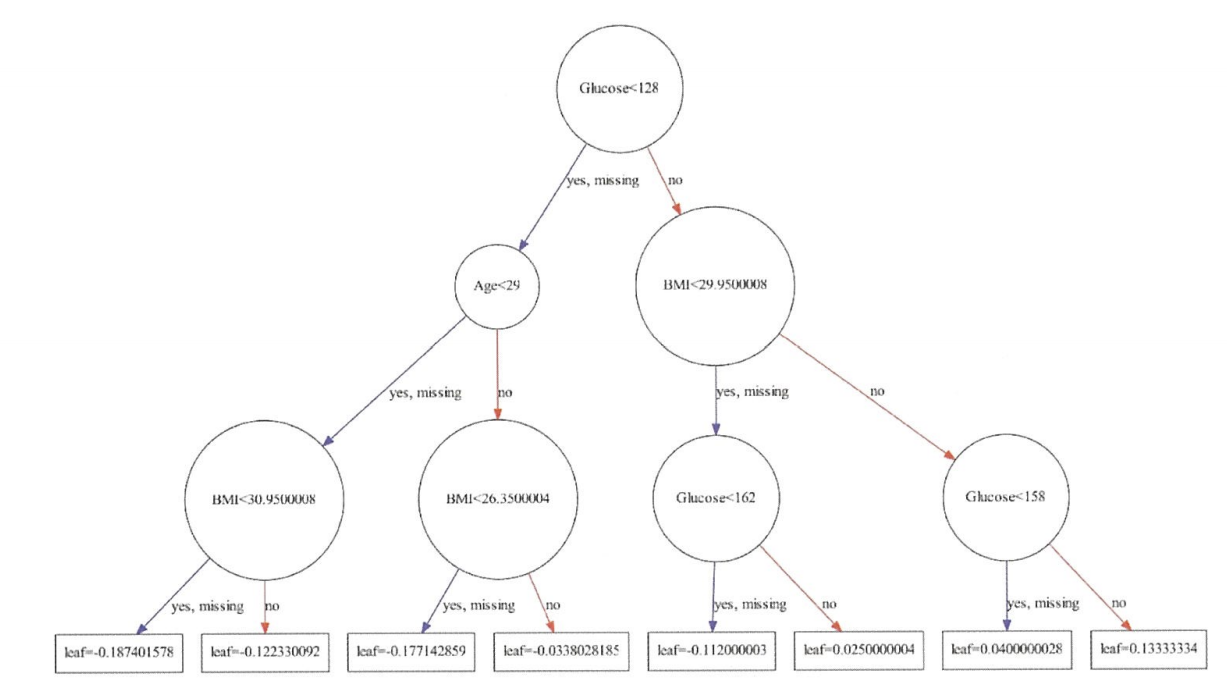

In [26]:
# 예제 4.15 GridSearchCV를 통해 당뇨병 진단 모델의 최적 하이퍼파라미터를 찾는 코드
import numpy as np
from sklearn.model_selection import GridSearchCV

#조사하고 싶은 모델 파라미터
cv_params = {
    'max_depth': np.arange(1, 6, 1),
}

#모델에 적용할 고정 파라미터
fix_params = {
    'booster': 'gbtree', 'objective': 'binary:logistic',
}

csv = GridSearchCV(
    XGBClassifier(**fix_params),
    cv_params,
    scoring = 'precision',
    cv = 5,
    n_jobs=5
)

csv.fit(x_train, y_train)
print(csv.best_params_)

# make predictions for test data
y_pred = csv.predict(x_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


{'max_depth': 1}
Accuracy: 77.92%


In [27]:
# 예제 4.17 GridSearchCV를 사용해 max_depth, learning_rate, n_estimators 파라미터값 변화에 대한 최적의 모델을 찾는 코드

import numpy as np
from sklearn.model_selection import GridSearchCV
cv_params = {
    'max_depth': np.arange(1, 6, 1),
    'learning_rate': np.arange(0.05, 0.6, 0.05),
    'n_estimators': np.arange(50, 300, 50),
}
fix_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
}
csv = GridSearchCV(
    XGBClassifier( **fix_params),
    cv_params,
    scoring = 'precision',
    cv = 5,
    n_jobs=5
)
csv.fit(x_train, y_train)
# show best parameter score
print(csv.best_params_)
# make predictions for test data

y_pred = csv.predict(x_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# show every combination parameter in Grid Search

for parameter in csv.cv_results_["params"]:
    print(parameter)


{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}
Accuracy: 75.97%
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 50}
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100}
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 150}
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 200}
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 250}
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 250}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250}
{'learning_r

In [28]:
# 예제 4.19 GridSearchCV로 찾아낸 당뇨병 진단 모델의 최적 파라미터

model = XGBClassifier(
    booster = 'gbtree',
    objective = 'binary:logistic',
    learning_rate = 0.03,
    n_estimators =  150,
    reg_alpha = 0.15,
    reg_lambda = 0.7,
    max_depth = 4
)

Accuracy: 84.42%


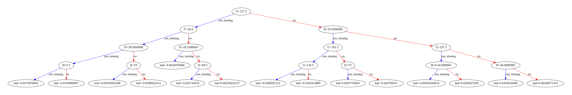

In [29]:
# 모델 학습 시키기
model.fit(x_train, y_train)
# make predictions
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluations
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%' % (accuracy * 100.0))


plot_tree(model)
plt.show()

In [30]:
# 예제 4.20 sklearn 패키지로 컨퓨전 행렬을 계산하는 코드

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[88  9]
 [15 42]]


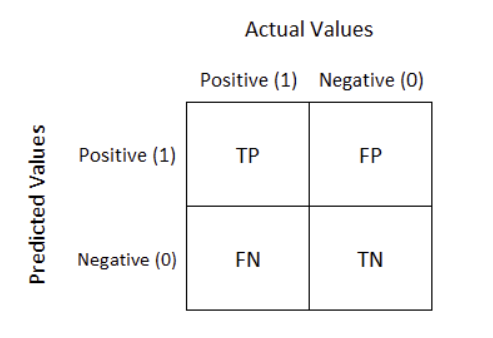

예를 들어, 환자의 암을 예측하는 모델이라고 했을 때

 

실제 환자가 암이고, 예측 결과도 암이면 True Positive(TP)

실제 환자는 암이지만, 예측 결과는 정상이면 False Negative(FN)

실제 환자는 정상이지만, 예측 결과가 암이라면 False Positive(FP)

실제 환자는 정상이고, 예측결과도 정상이면 True Negative(TN)

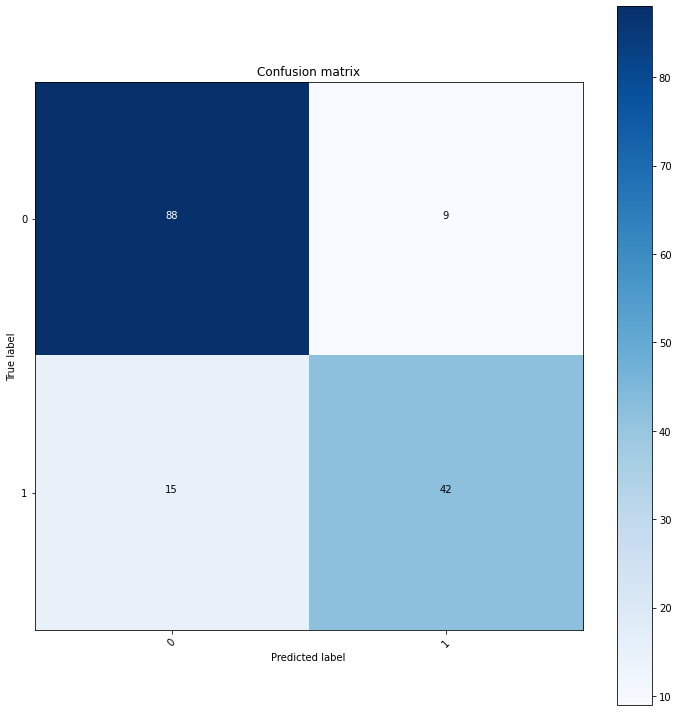

Precision = 0.824
Recall (TPR) = 0.737
Fallout (FPR) = 9.278e-02


(0.8235294117647058, 0.7368421052631579, 0.09278350515463918)

In [31]:
# 예제 4.22 sklearn 패키지로 계산한 컨퓨전 행렬을 matplotlib을 통해 시각화하는 코드

import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision = {:.3f}'.format(tp/(tp+fp)))
    print('Recall (TPR) = {:.3f}'.format(tp/(tp+fn)))
    print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))

    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

plot_confusion_matrix(cm, ['0', '1'], )
show_data(cm, print_res=1)
